In [37]:
from abtem.measure import integrate_disc
from abtem import *
from abtem.structures import orthogonalize_cell

import matplotlib.pyplot as plt
import numpy as np

from scipy import optimize
from ase.data import chemical_symbols
from ase.build import graphene

def fit_power_law(xdata, ydata):
    logxdata = np.log10(xdata)
    logydata = weights = np.log10(ydata)

    fitfunc = lambda p, x: p[0] + p[1] * x   
    errfunc = lambda p, x, y, weights: (y - fitfunc(p, x)) / weights

    result = optimize.leastsq(errfunc, [1.0, 2.0], args=(logxdata, logydata, weights))
    return result[0][1]

<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>

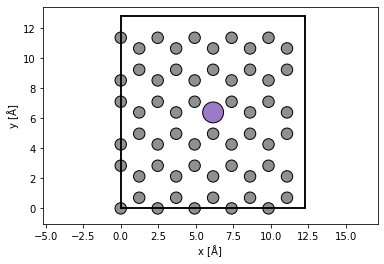

In [38]:
atoms = orthogonalize_cell(graphene())
atoms *= (5, 3, 1)
atoms.center(vacuum=4, axis=2)
atoms[30].number = 25

show_atoms(atoms)

In [39]:
probe = Probe(energy=60e3, semiangle_cutoff=30, rolloff=0.1, defocus=10, Cs=-15e4, focal_spread=50)

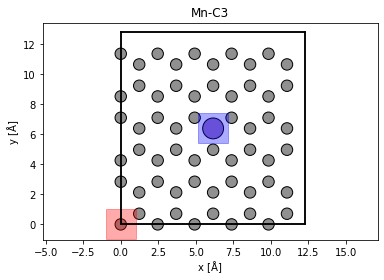

In [40]:
integration_radius = .5

atom1 = 0
atom2 = 30

center1 = atoms[atom1].position[:2]
center2 = atoms[atom2].position[:2]

sampling = probe.ctf.nyquist_sampling*.9/4

gridscan1 = GridScan(start=[center1[0] - integration_radius*2, center1[1] - integration_radius*2], 
                     end=[center1[0] + integration_radius*2, center1[1] + integration_radius*2], 
                     sampling=sampling,
                     endpoint=True)

gridscan2 = GridScan(start=[center2[0] - integration_radius*2, center2[1] - integration_radius*2], 
                     end=[center2[0] + integration_radius*2, center2[1] + integration_radius*2], 
                     sampling=sampling,
                     endpoint=True)

ax = show_atoms(atoms, title='Mn-C3')
gridscan1.add_to_mpl_plot(ax)
gridscan2.add_to_mpl_plot(ax, facecolor='b', edgecolor='b')

In [41]:
potential = Potential(atoms, sampling=.04, parametrization='lobato')

detector = AnnularDetector(inner=60, outer=200)

In [42]:
measurement1 = probe.scan(gridscan1, detector, potential, pbar=True)
measurement2 = probe.scan(gridscan2, detector, potential, pbar=True)

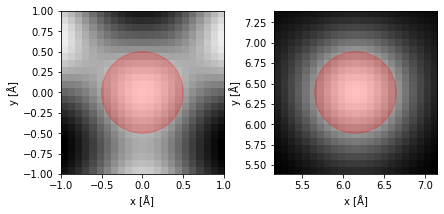

In [43]:
fig,(ax1,ax2)=plt.subplots(1, 2, figsize=(7,3))

measurement1.show(ax=ax1)
measurement2.show(ax=ax2)

circle1 = plt.Circle(center1, integration_radius, facecolor='r', alpha=.25, edgecolor='r')
circle2 = plt.Circle(center2, integration_radius, facecolor='r', alpha=.25, edgecolor='r')

ax1.add_artist(circle1)
ax2.add_artist(circle2)

In [44]:
value1 = integrate_disc(measurement1, center1, integration_radius, border='raise')
value2 = integrate_disc(measurement2, center2, integration_radius, border='raise')

In [46]:
Z = [atoms[atom1].number, atoms[atom2].number]
ratio = value2 / value1
power = fit_power_law(Z, [value1, value2])

print(f'intensity ratio: {chemical_symbols[Z[1]]} / {chemical_symbols[Z[0]]}: {ratio:.3f}')
print(f'power law: ({Z[1]} / {Z[0]}) ** {power:.3f} = {ratio:.3f}')

intensity ratio: Mn / C: 10.611
power law: (25 / 6) ** 1.655 = 10.611
